# Прореживание нейронных сетей

В этой лабораторной мы попробуем уменьшить размер нейронной сети за счет удаления из нее части весов. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [2]:
SEED=9876
torch.manual_seed(SEED)

В качестве данных будем использовать стандартный mnist

In [3]:
df = pd.read_csv('/data/mnist_784.csv')
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [4]:
y = df['class'].values
X = df.drop(['class'],axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

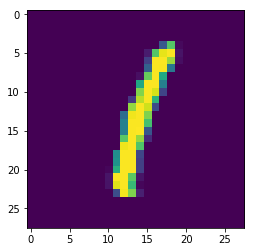

In [5]:
plt.imshow(X_train[0].reshape(28, 28))


Первое, что мы попробуем сделать - это собрать какую-то несложную архитектуру нейронной сети и просто обучить ее на данных. 

После этого мы замерим ее размер, а также качество, которое она выдает. Все дальнейшие полученные модели будем сравнивать с этими результатами, как с базовыми и понимать - получилось лучше или хуже.

Вначале просто подготовим данные для обучения.

In [6]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

В реальной жизни для задачи распознавания числа на картинке мы бы скорее всего использовали более продвинутую архитектуру сети, однако для наглядности мы возьмем простую сеть, которая при этом имеет много параметров. В ней будут просто три полносвязных слоя: 784 - 250 - 100 - 10

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


Обучаем самым обычным способом, используя кросс-энтропию в качестве меры ошибки и используя 5 эпох

In [8]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epoch_number):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [9]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 8.752556	 Accuracy:9.375%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.328136	 Accuracy:69.179%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.348056	 Accuracy:76.825%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.260351	 Accuracy:79.988%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.274883	 Accuracy:82.478%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.284315	 Accuracy:83.877%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.142769	 Accuracy:84.759%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.533784	 Accuracy:85.684%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.383286	 Accuracy:86.386%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.217748	 Accuracy:86.973%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.247283	 Accuracy:87.512%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.306317	 Accuracy:87.891%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.753405	 Accuracy:88.176%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.040594	 Accuracy:88.599%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.437389	 Accuracy:88.820%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.134156	 Accuracy:89.073%
Epoch 

Epoch : 4 [12800/49000 (26%)]	Loss: 0.485813	 Accuracy:96.875%
Epoch : 4 [14400/49000 (29%)]	Loss: 0.022930	 Accuracy:96.910%
Epoch : 4 [16000/49000 (33%)]	Loss: 0.043097	 Accuracy:96.894%
Epoch : 4 [17600/49000 (36%)]	Loss: 0.005847	 Accuracy:96.886%
Epoch : 4 [19200/49000 (39%)]	Loss: 0.220363	 Accuracy:96.906%
Epoch : 4 [20800/49000 (42%)]	Loss: 0.004355	 Accuracy:96.913%
Epoch : 4 [22400/49000 (46%)]	Loss: 0.076977	 Accuracy:96.866%
Epoch : 4 [24000/49000 (49%)]	Loss: 0.036896	 Accuracy:96.850%
Epoch : 4 [25600/49000 (52%)]	Loss: 0.017019	 Accuracy:96.832%
Epoch : 4 [27200/49000 (55%)]	Loss: 0.392278	 Accuracy:96.827%
Epoch : 4 [28800/49000 (59%)]	Loss: 0.010164	 Accuracy:96.868%
Epoch : 4 [30400/49000 (62%)]	Loss: 0.065720	 Accuracy:96.849%
Epoch : 4 [32000/49000 (65%)]	Loss: 0.001300	 Accuracy:96.856%
Epoch : 4 [33600/49000 (69%)]	Loss: 0.066023	 Accuracy:96.854%
Epoch : 4 [35200/49000 (72%)]	Loss: 0.080354	 Accuracy:96.847%
Epoch : 4 [36800/49000 (75%)]	Loss: 0.148589	 Accuracy:

В качестве метрики качества возьмем обычный accuracy

In [10]:
def evaluate(model):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))

evaluate(mlp)

Test accuracy:0.956% 


Весьма неплохое качество, учитывая, что мы почти ничего не придумывали с сетью.

Посмотрим, сколько параметров нам потребовалось, чтобы получить это качество.

In [11]:
def calc_weights(model):
    result = 0
    for layer in model.children():
        result += len(layer.weight.reshape(-1))
    return result

In [12]:
calc_weights(mlp)

222000

Видно, что полносвязные слои достаточно тяжелые и всего три слоя дали нам больше чем 200 000 параметров. Попробуем ужать это число, не сильно уменьшим при этом качество.

# Удаляем связи внутри сети

Для того, чтобы начать оптимизировать размер сети, нам нужен инструментарий для удаления связей внутри нашей модели.

Нам потребуется особый полносвязный слой, в котором мы можем отключать конкретные веса. Используя такие слои, соберем такую же архитектруру с тремя полносвязными.

Отключать сами веса мы будем исходя из их абсолютного значения - задавая пороговое значение, мы будем занулять только те веса, которые меньше этого значения.

In [13]:
class MaskedLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(MaskedLinear, self).__init__()
        # Обычный полносвязный слой
        self._linear = nn.Linear(in_size, out_size) 
        # Маска для слоя. Для связи из оригинального слоя, здесь будут хранится 0 и 1. 
        # 1 - связь действует, 0 - связь не действует.
        self._mask = nn.Linear(in_size, out_size)
        # Изначально все числа в маске - 1. То есть изначально мы не выключаем вообще никакие веса
        self._mask.weight.data = torch.ones(self._mask.weight.size())
    
    def forward(self, x):
        # Чтобы применить этот слой, нужно вначале умножить веса на маску. 
        # Тогда те веса, которые мы выключили, занулятся, что и будет означать, что мы их просто выкинули
        self._linear.weight.data = torch.mul(self._linear.weight, self._mask.weight)
        return self._linear(x)
    
    def prune(self, threshold):
        # Для того, чтобы выключить часть связей задается threshold
        # Если значение веса по модулю в сети меньше, чем threshold, то мы его выключаем, а значит выставляем 0 в маске.
        self._mask.weight.data = torch.mul(torch.gt(torch.abs(self._linear.weight), threshold).float(), self._mask.weight)

Составляем точно такую же архитектуру, но используя наши особенные полносвязные слои, в которых мы можем отключать веса

In [14]:
class AutoCompressMLP(nn.Module):
    def __init__(self):
        super(AutoCompressMLP, self).__init__()
        self.linear1 = MaskedLinear(784,250)
        self.linear2 = MaskedLinear(250,100)
        self.linear3 = MaskedLinear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, threshold):
        self.linear1.prune(threshold)
        self.linear2.prune(threshold)
        self.linear3.prune(threshold)

Чтобы удалить какую-то долю связей из сети, необходимо вначале подсчитать необходимое пороговое значение. 

Так, чтобы удалить N% связей по этой схеме, необходимо найти такое число, чтобы ровно N% связей имело вес меньше этого числа по модулю. Другими словами найти N-перцентиль.

Напишем функцию, которая будет искать такое пороговое значение.

In [15]:
def calc_threshhold(model, rate):
    all_weights = torch.Tensor()
    for layer in model.children():
        all_weights = torch.cat( (layer._linear.weight.view(-1), all_weights.view(-1)) )
    abs_weight = torch.abs(all_weights)
    
    return np.percentile(abs_weight.detach().cpu().numpy(), rate)

In [16]:
acmlp = AutoCompressMLP()
t = calc_threshhold(acmlp, 50.0)
t

0.018921107985079288

Чтобы следить за тем, сколько параметров осталось внури нашей сети, нам потребуется немного другая функция подсчета активных весов, учитываящая маску.

In [17]:
def calc_pruned_weights(model):
    result = 0
    for layer in model.children():
        result += torch.sum(layer._mask.weight.reshape(-1))
    return int(result.item())

In [18]:
acmlp.prune(t)
calc_pruned_weights(acmlp)

111000

# Итеративное прореживание

Идин из способов сжатия нейронных сетей - итеративное прореживание (Incremental Magnitude Pruning). Он достаточно ресурсоемкий, однако позволяет достаточно несложными методами добиться неплохого результата.

In [19]:
acmlp = AutoCompressMLP()

Вначале просто обучим нашу модель, никаким образом ее не модифицируя.

In [ ]:
torch.manual_seed(SEED)
fit(acmlp, train_loader)

Epoch : 0 [0/49000 (0%)]	Loss: 12.148988	 Accuracy:3.125%
Epoch : 0 [1600/49000 (3%)]	Loss: 0.237205	 Accuracy:67.525%
Epoch : 0 [3200/49000 (7%)]	Loss: 0.358010	 Accuracy:76.269%
Epoch : 0 [4800/49000 (10%)]	Loss: 0.351805	 Accuracy:80.215%
Epoch : 0 [6400/49000 (13%)]	Loss: 0.419410	 Accuracy:82.494%
Epoch : 0 [8000/49000 (16%)]	Loss: 0.394660	 Accuracy:83.914%
Epoch : 0 [9600/49000 (20%)]	Loss: 0.127043	 Accuracy:84.904%
Epoch : 0 [11200/49000 (23%)]	Loss: 0.453196	 Accuracy:85.791%
Epoch : 0 [12800/49000 (26%)]	Loss: 0.129024	 Accuracy:86.300%
Epoch : 0 [14400/49000 (29%)]	Loss: 0.390616	 Accuracy:86.918%
Epoch : 0 [16000/49000 (33%)]	Loss: 0.394425	 Accuracy:87.406%
Epoch : 0 [17600/49000 (36%)]	Loss: 0.159227	 Accuracy:87.721%
Epoch : 0 [19200/49000 (39%)]	Loss: 0.622173	 Accuracy:88.036%
Epoch : 0 [20800/49000 (42%)]	Loss: 0.122171	 Accuracy:88.431%
Epoch : 0 [22400/49000 (46%)]	Loss: 0.733558	 Accuracy:88.788%
Epoch : 0 [24000/49000 (49%)]	Loss: 0.181110	 Accuracy:89.023%
Epoch

In [ ]:
evaluate(acmlp)

Отлично, получили примерно такую же модель, как и в самом начале. 

Сейчас модель уже имеет хорошие веса для предсказаний. Теперь попробуем убрать из нее 50% связей и посмотрим, насколько ей удастся сохранить качество.

Как уже отмечалось, отключим 50% наиболее слабых связей в сети.

In [ ]:
import copy

acmlp_test1 = copy.deepcopy(acmlp)

In [ ]:
t_50 = calc_threshhold(acmlp_test1, 50.0)
acmlp_test1.prune(t_50)

In [ ]:
evaluate(acmlp_test1)

Можно заметить, что таким образом выкинутые веса почти не повлияли на качество сети. При этом мы выкинули половину всех коэффициентов! Весьма неплохой результат.

Давайте посмотрим, можем ли мы с таким же успехом выкинуть 90% сети?

In [ ]:
acmlp_test2 = copy.deepcopy(acmlp)

t_90 = calc_threshhold(acmlp_test2, 90.0)
acmlp_test2.prune(t_90)

In [ ]:
evaluate(acmlp_test2)

Увы, так просто выкинуть 90% и оставить качество не получается. Будем использовать более хитрый подход.

Будет идти с шагом в 10%. Каждый раз будет отключать внутри сети 10% связей. После отключения, оставшиеся веса дообучим на всех данных используя всего одну эпоху. Ожидается, что так как мы выкинули за один раз не очень много, то оставшиеся связи "перехватят" ответственность тех слабых, которые мы только что отключили.

Таким образом за P таких итераций мы выкинем 10P% всей сети и не должны при этом потерять сильно в качестве.

In [ ]:
def smart_prune(model, train_loader, compress_rate):
    # Создаем именно новую модель, старую не трогаем
    model = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for rate in range(0, compress_rate+1, 10):  # Идем с шагом в 10%
        t = calc_threshhold(model, float(rate))  # Считаем очередное пороговое значение
        model.prune(t)  # Отключаем слабые связи
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):  # Далее дообучаем модель как обычно в течение одной эпохи
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 20 == 0:
                print('Rate : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    rate, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return model

Попробуем для начала выкинуть 70% таким образом

In [ ]:
torch.manual_seed(SEED)
pruned_model = smart_prune(acmlp, train_loader, 70)

In [ ]:
evaluate(pruned_model)

На моем компьютере получилось качество около 0.97. Формально это даже чуточку лучше, чем оригинальная модель! Получается, что лишние веса в оригинальной модели могли мешали выявить зависимость в данных. 

Давайте посчитаем количество ненулевых весов в модели

In [ ]:
calc_pruned_weights(acmlp)

In [ ]:
calc_pruned_weights(pruned_model)

Оставили около 60 000 весов, мы получили почти такое же качество для модели!

Можем ли мы таким же образом выкинуть 90%?

In [ ]:
torch.manual_seed(SEED)
pruned_model_90 = smart_prune(acmlp, train_loader, 90)

In [ ]:
evaluate(pruned_model_90)

In [ ]:
calc_pruned_weights(pruned_model_90)

Выкинув большую часть сети, мы все еще имеем относительно неплохое качество, хоть и меньше, чем изначально. 

Вполне возможно проблема в том, что мы слишком агрессивно удаляем связи, когда их остается совсем мало. Давайте попробуем более аккуратные шаги.


In [ ]:
def smart_prune_shed(model, train_loader, schedule):
    # Создаем именно новую модель, старую не трогаем
    model = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for rate, epochs in schedule:  # Идем шагами, согласно тому расписанию, которое передали в функцию
        t = calc_threshhold(model, float(rate))  # Считаем очередное пороговое значение
        model.prune(t)  # Отключаем слабые связи
        for i in range(epochs):
            correct = 0
            for batch_idx, (X_batch, y_batch) in enumerate(train_loader):  # Далее дообучаем модель как обычно в течение указанного количества эпох
                var_X_batch = Variable(X_batch).float()
                var_y_batch = Variable(y_batch)
                optimizer.zero_grad()
                output = model(var_X_batch)
                loss = error(output, var_y_batch)
                loss.backward()
                optimizer.step()

                predicted = torch.max(output.data, 1)[1] 
                correct += (predicted == var_y_batch).sum()
                if batch_idx % 20 == 0:
                    print('Rate : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                        rate, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
    return model

In [ ]:
torch.manual_seed(SEED)
pruned_model_90 = smart_prune_shed(acmlp, train_loader, [
    (0, 1), 
    (20, 1), 
    (40, 1), 
    (50, 1), 
    (60, 1), 
    (70, 1), 
    (75, 1), 
    (80, 2), 
    (83, 2), 
    (85, 2), 
    (86, 2), 
    (87, 2), 
    (88, 2), 
    (89, 2), 
    (90, 2)
])

In [ ]:
evaluate(pruned_model_90)

In [ ]:
calc_pruned_weights(pruned_model_90)

Чтож, это оригинальное качество за всего 10% сети.

Ради интереса попробуем "дожать до победы" и удалим 99%.

In [ ]:
torch.manual_seed(SEED)
pruned_model_99 = smart_prune_shed(pruned_model_90, train_loader, [
    (90, 2),
    (92, 2),
    (94, 2),
    (95, 2),
    (96, 2),
    (97, 2),
    (98, 2),
    (99, 2)
])

In [ ]:
evaluate(pruned_model_99)

In [ ]:
calc_pruned_weights(pruned_model_99)

Видно, что метод все таки имеет свои ограничения. По логу видно, что где-то в районе 94% мы видимо задели какой-то очень важный участок сети, после удаления которого она уже не смогла восстановится.

Однако результат в 90% - это тоже вполне неплохо!

# Готовые реализации

Сама техника достаточно популярна и часто имеет уже готовые реализации. В Pytorch имеется отдельный модуль для проведения прореживания сети.

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
class PytorchPrunedMLP(nn.Module):
    def __init__(self):
        super(PytorchPrunedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, rate):
        # Используем l1_unstructured вместо нашего подхода
        # unstructured говорит о том, что нет ограничений на удаляемые веса
        # l1 говорит о том, что нужно смотреть на модуль веса
        prune.l1_unstructured(self.linear1, 'weight', amount=rate)
        prune.l1_unstructured(self.linear2, 'weight', amount=rate)
        prune.l1_unstructured(self.linear3, 'weight', amount=rate)

In [ ]:
torch.manual_seed(SEED)
ppmlp = PytorchPrunedMLP()
fit(ppmlp, train_loader)

In [ ]:
evaluate(ppmlp)

In [ ]:
ppmlp.prune(0.5)

In [ ]:
evaluate(ppmlp)

In [ ]:
def calc_pytorch_weights(model):
    result = 0
    for layer in model.children():
        if hasattr(layer, 'weight_mask'):
            result += int(torch.sum(layer.weight_mask.reshape(-1)).item())
        else:
            result += len(layer.weight.reshape(-1))
    return result

In [ ]:
calc_pytorch_weights(ppmlp) 

Точно таким же образом мы только что выкинули 50% самых слабый весов из сети.

# Групповое (структурированное) прореживание

В библиотеке реализованы также и более продвинутые версии этого алгоритма. Например мы можем делать более структурированное прореживание, удаляя не единичные связи, а целиком нейроны из сети. 

Для того, чтобы понять, насколько тот или иной нейрон важен для работы сети, будем смотреть на все веса, связанные с ним. Если веса значительно отличаются от нуля, значит нейрон важный, если близки к нулю - значит скорее всего его можно удалить.

Понимать, насколько группа нейронов близка к нулю можно разными способами. Наиболее популярный - L-нормы. Так например при L1 мы будем смотреть на сумму по модулю все весов для нейрона, а при L2 - на корень из суммы квадратов весов.

In [ ]:
class StructuredPrunedMLP(nn.Module):
    def __init__(self):
        super(StructuredPrunedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
    
    def prune(self, rate):
        # Используем ln_structured для удаления нейронов целиком
        # Для оценивания значимости нейрона будем использовать L2, поэтому указываем n=2
        # Указываем dim=1 - это укажет, как именно нужно групировать веса. Для dim=1 - это группировка по нейронам
        prune.ln_structured(self.linear1, 'weight', amount=rate, n=2, dim=1)
        prune.ln_structured(self.linear2, 'weight', amount=rate, n=2, dim=1)
        # В последнем слое удалять нейроны нельзя, потому как они отвечают за ответ сети

In [ ]:
torch.manual_seed(SEED)
spmlp = StructuredPrunedMLP()
fit(spmlp, train_loader)

In [ ]:
evaluate(spmlp)

In [ ]:
spmlp.prune(0.5)

In [ ]:
evaluate(spmlp)

In [ ]:
calc_pytorch_weights(spmlp)

Можно посмотреть на устройство весов в наших последних двух моделях

У модели, которую прореживали по весам, у каждого нейрона отключены какие-то элементы

In [ ]:
ppmlp.linear1.weight_mask.T[0]

У модели, которую прореживали по нейронам, нейрон или отключен совсем

In [ ]:
spmlp.linear1.weight_mask.T[0]

Или работает целиком

In [ ]:
spmlp.linear1.weight_mask.T[100]